# FAKE NEWS DETECTION USING SVM & LogR  


#### Code provided by Sayandeep Maity, Romak Das, Sreyam Prasad Das, Tilok Saha, Rahul Murmu

#### on 9th June,2020

#### @ 11:00 AM



## DATA PROCESSING

In [1]:
import pandas as pd
import csv
import numpy as np
import nltk
from nltk.stem import SnowballStemmer
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import word_tokenize
import seaborn as sb

In [2]:
test_filename = 'test.csv'
train_filename = 'train.csv'

train_news = pd.read_csv(train_filename)
test_news = pd.read_csv(test_filename)

In [3]:
def data_obs():
    print("training dataset size:")
    print(train_news.shape)
    print(train_news.head(10))

    print(test_news.shape)
    print(test_news.head(10))

data_obs()

training dataset size:
(10240, 2)
                                           Statement  Label
0  Says the Annies List political group supports ...  False
1  When did the decline of coal start? It started...   True
2  Hillary Clinton agrees with John McCain "by vo...   True
3  Health care reform legislation is likely to ma...  False
4  The economic turnaround started at the end of ...   True
5  The Chicago Bears have had more starting quart...   True
6  Jim Dunnam has not lived in the district he re...  False
7  I'm the only person on this stage who has work...   True
8  However, it took $19.5 million in Oregon Lotte...   True
9  Says GOP primary opponents Glenn Grothman and ...   True
(2551, 2)
                                           Statement  Label
0  Building a wall on the U.S.-Mexico border will...   True
1  Wisconsin is on pace to double the number of l...  False
2  Says John McCain has done nothing to help the ...  False
3  Suzanne Bonamici supports a plan that will cut...   T

In [4]:
def create_distribution(dataFile):
    return sb.countplot(x='Label', data=dataFile, palette='hls')

In [5]:
def data_qualityCheck():
    
    print("Checking data qualitites...")
    train_news.isnull().sum()
    train_news.info()
        
    print("check finished.")

    #below datasets were used to 
    test_news.isnull().sum()
    test_news.info()

data_qualityCheck()

Checking data qualitites...
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10240 entries, 0 to 10239
Data columns (total 2 columns):
Statement    10240 non-null object
Label        10240 non-null bool
dtypes: bool(1), object(1)
memory usage: 90.1+ KB
check finished.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2551 entries, 0 to 2550
Data columns (total 2 columns):
Statement    2551 non-null object
Label        2551 non-null bool
dtypes: bool(1), object(1)
memory usage: 22.5+ KB


In [6]:
def stem_tokens(tokens, stemmer):
    stemmed = []
    for token in tokens:
        stemmed.append(stemmer.stem(token))
    return stemmed


In [7]:
def process_data(data,exclude_stopword=True,stem=True):
    tokens = [w.lower() for w in data]
    tokens_stemmed = tokens
    tokens_stemmed = stem_tokens(tokens, eng_stemmer)
    tokens_stemmed = [w for w in tokens_stemmed if w not in stopwords ]
    return tokens_stemmed


In [8]:
def create_unigram(words):
    assert type(words) == list
    return words


In [9]:
def create_bigrams(words):
    assert type(words) == list
    skip = 0
    join_str = " "
    Len = len(words)
    if Len > 1:
        lst = []
        for i in range(Len-1):
            for k in range(1,skip+2):
                if i+k < Len:
                    lst.append(join_str.join([words[i],words[i+k]]))
    else:
        lst = create_unigram(words)
    return lst


In [10]:
def tokenizer(text):
    return text.split()

In [11]:
def tokenizer_porter(text):
    return [porter.stem(word) for word in text.split()]

## FEATURE SELECTION 

In [12]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
import nltk.corpus 

In [13]:
countV = CountVectorizer()
train_count = countV.fit_transform(train_news['Statement'].values)

In [14]:
def get_countVectorizer_stats():
    

    train_count.shape

    print(countV.vocabulary_)


    print(countV.get_feature_names()[:25])


In [15]:
tfidfV = TfidfTransformer()
train_tfidf = tfidfV.fit_transform(train_count)

In [16]:
def get_tfidf_stats():
    train_tfidf.shape
    print(train_tfidf.A[:10])
    

In [17]:
tfidf_ngram = TfidfVectorizer(stop_words='english',ngram_range=(1,4),use_idf=True,smooth_idf=True)


tagged_sentences = nltk.corpus.treebank.tagged_sents()

cutoff = int(.75 * len(tagged_sentences))
training_sentences = train_news['Statement']
 
print(training_sentences)

0        Says the Annies List political group supports ...
1        When did the decline of coal start? It started...
2        Hillary Clinton agrees with John McCain "by vo...
3        Health care reform legislation is likely to ma...
4        The economic turnaround started at the end of ...
5        The Chicago Bears have had more starting quart...
6        Jim Dunnam has not lived in the district he re...
7        I'm the only person on this stage who has work...
8        However, it took $19.5 million in Oregon Lotte...
9        Says GOP primary opponents Glenn Grothman and ...
10       For the first time in history, the share of th...
11       Since 2000, nearly 12 million Americans have s...
12       When Mitt Romney was governor of Massachusetts...
13       The economy bled $24 billion due to the govern...
14       Most of the (Affordable Care Act) has already ...
15       In this last election in November, ... 63 perc...
16       McCain opposed a requirement that the governme.

In [18]:
def features(sentence, index):
    return {
        'word': sentence[index],
        'is_first': index == 0,
        'is_last': index == len(sentence) - 1,
        'is_capitalized': sentence[index][0].upper() == sentence[index][0],
        'is_all_caps': sentence[index].upper() == sentence[index],
        'is_all_lower': sentence[index].lower() == sentence[index],
        'prefix-1': sentence[index][0],
        'prefix-2': sentence[index][:2],
        'prefix-3': sentence[index][:3],
        'suffix-1': sentence[index][-1],
        'suffix-2': sentence[index][-2:],
        'suffix-3': sentence[index][-3:],
        'prev_word': '' if index == 0 else sentence[index - 1],
        'next_word': '' if index == len(sentence) - 1 else sentence[index + 1],
        'has_hyphen': '-' in sentence[index],
        'is_numeric': sentence[index].isdigit(),
        'capitals_inside': sentence[index][1:].lower() != sentence[index][1:]
    }
    

## CLASSIFICATION

In [19]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import  LogisticRegression
from sklearn import svm
from sklearn.metrics import confusion_matrix, f1_score, classification_report
import matplotlib.pyplot as plt

In [20]:
#building classifier using logistic regression
logR_pipeline = Pipeline([
        ('LogRCV',countV),
        ('LogR_clf',LogisticRegression())
        ])
logR_pipeline.fit(train_news['Statement'],train_news['Label'])
predicted_LogR = logR_pipeline.predict(test_news['Statement'])
np.mean(predicted_LogR == test_news['Label'])

0.5985887887103096

In [21]:
#building classifier using SVM
svm_pipeline = Pipeline([
        ('svmCV',countV),
        ('svm_clf',svm.LinearSVC())
        ])

svm_pipeline.fit(train_news['Statement'],train_news['Label'])
predicted_svm = svm_pipeline.predict(test_news['Statement'])
np.mean(predicted_svm == test_news['Label'])



0.5723245785966288

### Using K-Fold plotting graphs

In [22]:
from sklearn.model_selection import KFold
import itertools
import collections

Total statements classified: 10240
Accuracy: 64.69090977975252
Confusion matrix:


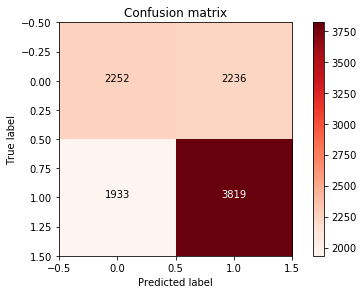

Total statements classified: 10240
Accuracy: 61.04687487924283
Confusion matrix:


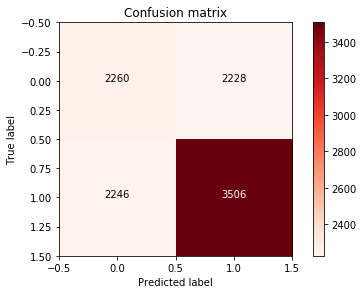

(None, None, None, None)

In [23]:
def plot_confusion_matrix(cm,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Reds):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    """

    plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 1.5
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        #cm[i, j] = 0 if np.isnan(cm[i, j]) else cm[i, j]
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="black" if cm[i, j] < thresh else "white")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
            
def build_confusion_matrix(classifier):
    
    k_fold = KFold(n_splits=5)
    scores = []
    confusion = np.array([[0,0],[0,0]])

    for train_ind, test_ind in k_fold.split(train_news):
        train_text =train_news.iloc[train_ind]['Statement'] 
        train_y = train_news.iloc[train_ind]['Label']
    
        test_text = train_news.iloc[test_ind]['Statement']
        test_y =train_news.iloc[test_ind]['Label']
        
        classifier.fit(train_text,train_y)
        predictions = classifier.predict(test_text)
        
        confusion += confusion_matrix(test_y,predictions)
        score = f1_score(test_y,predictions)
        scores.append(score)
        
        
    
    return (print('Total statements classified:', len(train_news)),
    print('Accuracy:', (sum(scores)/len(scores)*100)),
    print('Confusion matrix:'),
    plot_confusion_matrix(confusion))
            
            
            
            
#K-fold cross validation for all classifiers)
build_confusion_matrix(logR_pipeline)
build_confusion_matrix(svm_pipeline)



### To increase the accuracy  of the model now we have used n-grams

#### using n-gram

In [24]:
#logistic regression classifier suing n-gram
logR_pipeline_ngram = Pipeline([
        ('LogR_tfidf',tfidf_ngram),
        ('LogR_clf',LogisticRegression(penalty="l2",C=1))
        ])

logR_pipeline_ngram.fit(train_news['Statement'],train_news['Label'])
predicted_LogR_ngram = logR_pipeline_ngram.predict(test_news['Statement'])
np.mean(predicted_LogR_ngram == test_news['Label'])


0.6193649549196394

In [25]:
#linear SVM classifier using n-gram
svm_pipeline_ngram = Pipeline([
        ('svm_tfidf',tfidf_ngram),
        ('svm_clf',svm.LinearSVC())
        ])

svm_pipeline_ngram.fit(train_news['Statement'],train_news['Label'])
predicted_svm_ngram = svm_pipeline_ngram.predict(test_news['Statement'])
np.mean(predicted_svm_ngram == test_news['Label'])


0.6170129361034888

Total statements classified: 10240
Accuracy: 70.44355553757985
Confusion matrix:


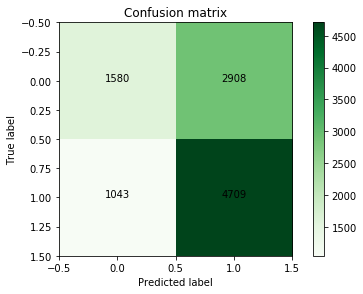

Total statements classified: 10240
Accuracy: 67.90920142902142
Confusion matrix:


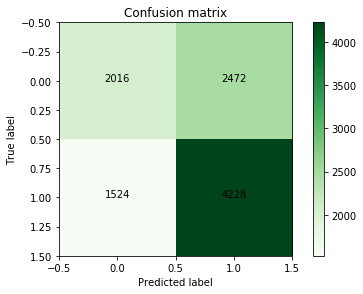

(None, None, None, None)

In [30]:
def plot_confusion_matrix(cm,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Greens):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    """

    plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 1.3
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        #cm[i, j] = 0 if np.isnan(cm[i, j]) else cm[i, j]
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="black" if cm[i, j] < thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
            
def build_confusion_matrix(classifier):
    
    k_fold = KFold(n_splits=5)
    scores = []
    confusion = np.array([[0,0],[0,0]])

    for train_ind, test_ind in k_fold.split(train_news):
        train_text =train_news.iloc[train_ind]['Statement'] 
        train_y = train_news.iloc[train_ind]['Label']
    
        test_text = train_news.iloc[test_ind]['Statement']
        test_y =train_news.iloc[test_ind]['Label']
        
        classifier.fit(train_text,train_y)
        predictions = classifier.predict(test_text)
        
        confusion += confusion_matrix(test_y,predictions)
        score = f1_score(test_y,predictions)
        scores.append(score)
        
        
    
    return (print('Total statements classified:', len(train_news)),
    print('Accuracy:', (sum(scores)/len(scores)*100)),
    print('Confusion matrix:'),
    plot_confusion_matrix(confusion))
            
            
            
            
#K-fold cross validation for all classifiers)
build_confusion_matrix(logR_pipeline_ngram)
build_confusion_matrix(svm_pipeline_ngram)


In [27]:
print(classification_report(test_news['Label'], predicted_LogR_ngram))
print(classification_report(test_news['Label'], predicted_svm_ngram))

             precision    recall  f1-score   support

      False       0.64      0.39      0.49      1169
       True       0.61      0.81      0.70      1382

avg / total       0.62      0.62      0.60      2551

             precision    recall  f1-score   support

      False       0.61      0.47      0.53      1169
       True       0.62      0.74      0.68      1382

avg / total       0.62      0.62      0.61      2551



### Creating Precision Recall curve

In [28]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

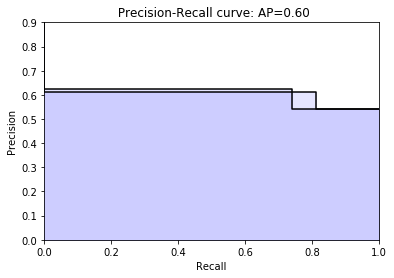

In [32]:
def plot_PR_curve(classifier):
    
    precision, recall, thresholds = precision_recall_curve(test_news['Label'], classifier)
    average_precision = average_precision_score(test_news['Label'], classifier)
    
    plt.step(recall, precision, color='black', alpha=1,
             where='post')
    plt.fill_between(recall, precision, step='post', alpha=0.1,
                     color='blue')
    
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 0.8])
    plt.xlim([0.0, 1.0])
    plt.title(' Precision-Recall curve: AP={0:0.2f}'.format(
              average_precision))
    
plot_PR_curve(predicted_LogR_ngram)
plot_PR_curve(predicted_svm_ngram)